# Mask Detection Demo - Serving (2 / 3)

The following example demonstrates a serving workflow that deploys the model to a Nuclio function, sends an http request with an image url and receives a 
response back with the probability that the person in the image is wearing a mask or not.

1. [Set up the Project](#section_1)
2. [Write the Serving Code](#section_2)
3. [Create the Serving Pipeline](#section_3)
4. [Test the Serving Pipeline](#section_4)
5. [Deploy a real-time serverless function](#section_5)

<a id="section_1"></a>
## 1. Setup the Project

Create a project using `mlrun.get_or_create_project` (make sure to load it in case it already exists), which creates the paths where we'll store the project's artifacts:

In [1]:
import mlrun
import os

# Set our project's name:
project_name = "mask-detection"

# Create the project:
project = mlrun.get_or_create_project(name=project_name, context="./", user_project=True)

> 2023-09-03 07:18:41,515 [info] Project loaded successfully: {'project_name': 'mask-detection'}


<a id="section_2"></a>
## 2. Write the Serving Code

Before we continue, **please select the desired framework** (comment and uncomment the below lines as needed):

In [2]:
# framework = "tf-keras"
framework = "pytorch"

### TF.Keras

The code is taken from the python file [serving.py](tf-keras/serving.py). Our data will go through the following structure:
1. `resize` - Read the URL into an array and resize it to 224x224.
2. `preprocess` - Use MobileNetV2 preprocessing function.
3. `mlrun.frameworks.tf_keras.TFKerasModelServer` - Infer the inputs through the model and return the predictions. It can be imported from:
    ```python
    from mlrun.frameworks.tf_keras import TFKerasModelServer
    ```
    This class can be inherited and its pre-process, post-process, predict and explain methods can be overridden. In this demo, we will be using the defaults to showcase the topology feature of our serving functions.
4. `post-process` - Parse the prediction probabilities and wrap them in a dictionary with which to respond.

### PyTorch

The code is taken from the python file [serving.py](pytorch/serving.py). Our data will go through the following structure:
1. `resize` - Read the URL into an array and resize it to 224x224.
2. `preprocess` - Use `torchvision.transforms` to normalize the images for MobileNetV2.
3. `mlrun.frameworks.pytorch.PyTorchModelServer` - Infer the inputs through the model and return the predictions. It can be imported from:
    ```python
    from mlrun.frameworks.pytorch import PyTorchModelServer
    ```
    This class can be inherited and its pre-process, post-process, predict and explain methods can be overridden. In this demo, we will be using the defaults to showcase the topology feature of our serving functions.
4. `post-process` - Parse the prediction probabilities and wrap them in a dictionary with which to respond.

<a id="section_3"></a>
## 3. Create the Serving Pipeline

The serving function kind is using [Nuclio](https://nuclio.io/): a high-performance serverless event 
and data processing open-source platform. With just a few lines of code we can take our model, **expose** it with an **http endpoint** and deploy it on 
**high-performance** infrastructure that can easily scale up to serve on a **production environment** with hundreds of 
thousands of requests per second. To read more about serving functions in MLRun and some cool advanced features like model routers, error handling and more, please refer to our [documentation](https://docs.mlrun.org/en/latest/serving/serving-graph.html).

Back to our demo: Use `mlrun.code_to_function` again to create the MLRun function as seen in the previous notebook:

In [3]:
# Create the function parsing this notebook's code using 'code_to_function':
serving_function = mlrun.code_to_function(
    filename=os.path.join(framework, "serving.py"),
    name="serving", 
    kind="serving", 
    image=f'.mask-detection-{framework}',
    with_doc=False
)

# Increase the time limit as the image may take long time to be downloaded:
serving_function.spec.readiness_timeout = 60 * 20  # 20 minutes.

In order to insert our functions flow, we will use `set_topology` and add our steps and model to the graph using `graph.to`:

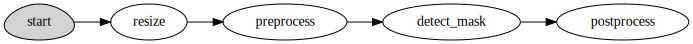

In [4]:
# Set the topology and get the graph object:
graph = serving_function.set_topology("flow", engine="async")

# Choose the ModelServer according to the selected framework:
model_server_class = (
    "mlrun.frameworks.tf_keras.TFKerasModelServer"
    if framework == "tf-keras"
    else "mlrun.frameworks.pytorch.PyTorchModelServer"
)

# Build the serving graph:
graph.to(handler="resize", name="resize")\
     .to(handler="preprocess", name="preprocess")\
     .to(class_name=model_server_class, name="detect_mask", model_path=project.get_artifact_uri("mask_detector"))\
     .to(handler="postprocess", name="postprocess").respond()

# Plot to graph:
graph.plot(rankdir='LR')

<a id="section_4"></a>
## 4. Test Our Serving Pipeline

We wish to test our serving pipeline before deploying it. First, lets declare the images urls we will test and a function to print the image and the prediction:

In [5]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# The local mock server is searching to import the functions, so here we simply import them from the file:
import sys
sys.path.insert(0, os.path.abspath(f"./{framework}"))
from serving import resize, preprocess, postprocess

In [6]:
# Our predictions headers:
classes = ["with mask", "without mask"]

In [7]:
# The image urls to use in the tests, feel free to add your own images and test them out:
image_urls = [
    'https://s3.envato.com/files/321053037/323%202020_June_PORTO_446-Edit.jpg',  # With mask
    'https://media.glamour.com/photos/5a425fd3b6bcee68da9f86f8/master/pass/best-face-oil.png'  # Without mask
]

In [8]:
def print_image_classification(image_url: str, prediction: dict):
    # Draw Image:
    response = requests.get(image_url)
    plt.imshow(Image.open(BytesIO(response.content)))
    
    # Print the prediction:
    print(f"Classified: {classes[prediction['class']]}\n")
    print(f"With mask probability:    {prediction['with_mask']}")
    print(f"Without mask probability: {prediction['without_mask']}")

### 4.1. "Deploy" Locally

To test our function, we will create a mock server (simulator) using the function `to_mock_server()` and test the graph with our images:

In [9]:
# Create our server:
server = serving_function.to_mock_server()

> 2023-09-03 07:19:00,772 [info] downloading v3io:///projects/mask-detection-iguazio/artifacts/distributed-training/0/mask_detector_custom_objects_map.json.json to local temp file
> 2023-09-03 07:19:00,779 [info] downloading v3io:///projects/mask-detection-iguazio/artifacts/distributed-training/0/mask_detector_custom_objects.zip.zip to local temp file
> 2023-09-03 07:19:02,002 [info] model detect_mask was loaded


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.


### 4.2. Run the Tests

In order to send the image url to the mock server, we will use the `server.test` method. This method expects two main arguments:
* `path` - Path to the method inside the `ModelServer`. We will be using the `predict` method.
* `body` - A JSON serializable input to send to our serving pipeline.

Classified: with mask

With mask probability:    0.7637215852737427
Without mask probability: 0.23627842962741852


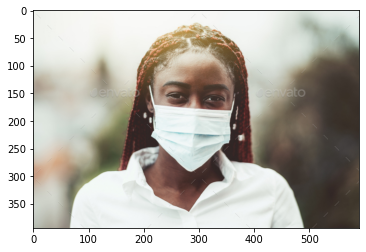

In [10]:
print_image_classification(
    image_url=image_urls[0], 
    prediction=server.test(path='/predict', body={"data_url": [image_urls[0]]})
)

Classified: without mask

With mask probability:    0.24980568885803223
Without mask probability: 0.7501943111419678


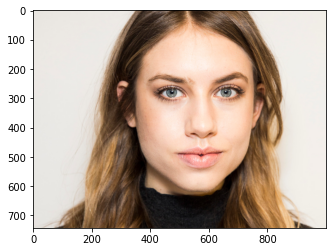

In [11]:
print_image_classification(
    image_url=image_urls[1], 
    prediction=server.test(path='/predict', body={"data_url": [image_urls[1]]})
)

<a id="section_5"></a>
## 5. Deploy a Realtime Serverless Function

### 5.1. Deploy

Now we will use the `serving_function.deploy` method to deploy our function as a real-time serverless function:

In [12]:
# Mount it:
serving_function.apply(mlrun.auto_mount())

In [13]:
# community edition mount support
if os.getenv('V3IO_ACCESS_KEY','False')=='False':    
    serving_function.spec.disable_auto_mount=False

In [14]:
# Deploy it:
serving_function.deploy()

> 2023-09-03 07:19:10,824 [info] Starting remote function deploy
2023-09-03 07:19:11  (info) Deploying function
2023-09-03 07:19:11  (info) Building
2023-09-03 07:19:11  (info) Staging files and preparing base images
2023-09-03 07:19:11  (info) Building processor image
2023-09-03 07:24:14  (info) Build complete
2023-09-03 07:25:08  (info) Function deploy complete
> 2023-09-03 07:25:17,902 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-mask-detection-iguazio-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['mask-detection-iguazio-serving-mask-detection-iguazio.default-tenant.app.dev6.lab.iguazeng.com/']}


'http://mask-detection-iguazio-serving-mask-detection-iguazio.default-tenant.app.dev6.lab.iguazeng.com/'

### 5.2. Infer Images Through Our Model

In order to send the image url to our deployed pipeline, we will use the `serving_function.invoke` method. This method expects the same two arguments as `server.test` seend above.

> 2023-09-03 07:25:17,960 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-mask-detection-iguazio-serving.default-tenant.svc.cluster.local:8080/predict'}
Classified: with mask

With mask probability:    0.7637215852737427
Without mask probability: 0.23627842962741852


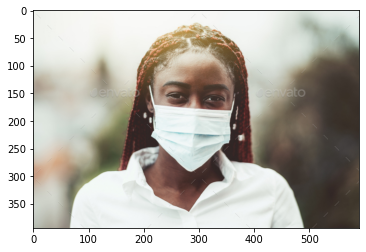

In [15]:
print_image_classification(
    image_url=image_urls[0], 
    prediction=serving_function.invoke(path='/predict', body={"data_url": [image_urls[0]]})
)

> 2023-09-03 07:25:18,860 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-mask-detection-iguazio-serving.default-tenant.svc.cluster.local:8080/predict'}
Classified: without mask

With mask probability:    0.24980567395687103
Without mask probability: 0.7501943111419678


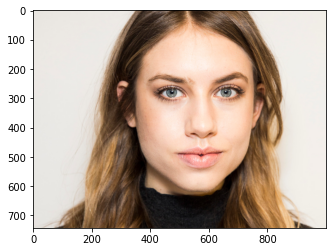

In [16]:
print_image_classification(
    image_url=image_urls[1], 
    prediction=serving_function.invoke(path='/predict', body={"data_url": [image_urls[1]]})
)